# Differentiable Uncalibrated Imaging

In [27]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchkbnufft as tkbn
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from tqdm import tqdm

In [5]:
def init_phantom(size=64):
    image = shepp_logan_phantom().astype(np.float32)  # Shape format (H,W)
    image = resize(image, (size, size), anti_aliasing=True)
    image = torch.tensor(image, dtype=torch.float)
    image = (image + 1j * torch.zeros_like(image)).unsqueeze(0).unsqueeze(0)
    return image

def init_kcoords(size=64, accel=2):
    kcoords = torch.rand(int(size * size / accel), 2) * 2 * np.pi - np.pi    
    return kcoords

def cpx2dim(x): return torch.cat([x.real, x.imag], dim=1)
def dim2cpx(x): return x[:,0] + 1j*x[:,1]

def imshow(ndarray, ax=None, title=''):
    show = False
    if ax is None:
        show = True
        ax = plt.gca()
    ax.imshow(np.squeeze(ndarray), cmap='gray')
    ax.set_axis_off()
    ax.set_title(title)
    if show: plt.show()

In [22]:
class MeasurementRepr(nn.Module):
    
    """ Measurement representation model """
    
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 256),   nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 2))   # Shape: (ksamples, 2); Dtype = float32

    def forward(self, kcoords):  # Shape: (ksamples, 2)
        return dim2cpx(self.mlp(kcoords)).unsqueeze(1)  # Shape: (ksamples, 1); Dtype = complex64

class ForwardOperator:

    def __init__(self, device='cpu'):
        # self.device = device
        self.nufft = tkbn.KbNufft(im_size=(64,64), device=device)
        self.inufft = tkbn.KbNufftAdjoint(im_size=(64,64), device=device)

    def set_coords(self, kcoords):
        self.kcoords = kcoords.T
        self.interp_matrices = tkbn.calc_tensor_spmatrix(self.kcoords.clone().detach(), im_size=(64,64))
        self.interp_matrices = (self.interp_matrices[0].to(kcoords.device), self.interp_matrices[1].to(kcoords.device))

    def __call__(self, image): 
        kdata = self.nufft(image, self.kcoords)  # Shape: (1, 1, ksamples); Dtype = complex64
        kdata = kdata.squeeze(0).T  # Shape: (ksamples, 1); Dtype = complex64
        return kdata
    
    def H(self, kdata):              # Shape: (ksamples, 1); Dtype = complex64
        kdata = kdata.T.unsqueeze(0) # Shape: (1, 1, ksamples); Dtype = complex64
        image = self.inufft(kdata, self.kcoords, self.interp_matrices)  # Shape: (1, 1, H, W); Dtype = complex64
        return image

class ReconstructorSimple:
    def __call__(self, kdata, A): return A.H(kdata)

In [23]:
def loss_fitting(kdata, kdata_pred_r):
    return torch.norm(kdata - kdata_pred_r, p=2)

def loss_consistency(kdata_pred_r, kdata_pred_ag):
    return torch.norm(kdata_pred_r - kdata_pred_ag, p=2)

In [24]:
device = 'cuda'

# Init stuff
R = MeasurementRepr().to(device)
A = ForwardOperator(device)
G = ReconstructorSimple()
image_gt = init_phantom().to(device)         # Shape: (1, 1, H, W); Dtype = complex64
kcoords_true = init_kcoords(accel=1.5).to(device)   # Shape: (ksamples, 2)
A.set_coords(kcoords_true)
kdata_true = A(image_gt).clone().detach()  # Shape: (ksamples, 1); Dtype = complex64

# # Sanity check
# recon = A.H(kdata)
# plt.imshow(recon.abs().squeeze().detach()); plt.show()


### Test kcoord optimization only

None
None
None
None
None
None
None
None
None
None
5062414.0


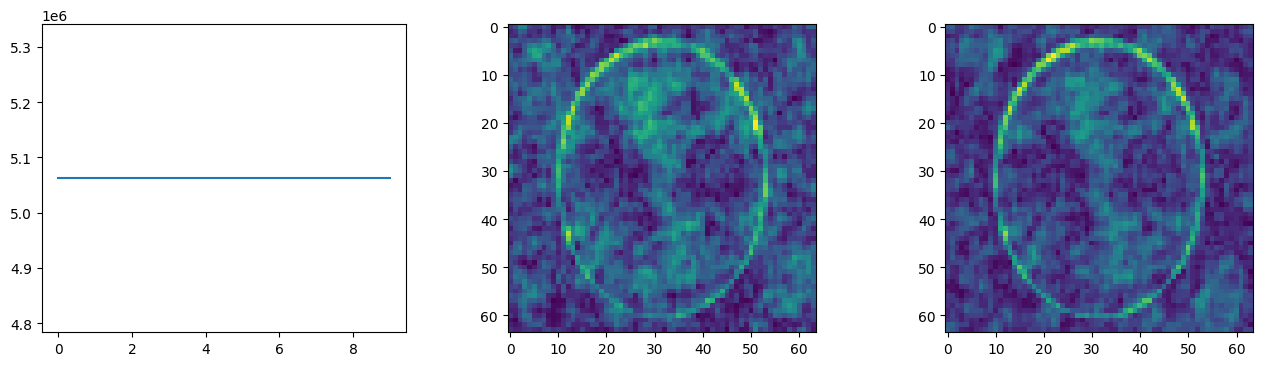

In [ ]:

# Optimization prep
kcoords = kcoords_true + torch.randn_like(kcoords_true) * torch.pi * 0.01  # Miscalibration
kcoords = kcoords.detach()
kcoords.requires_grad = True
optimizer = torch.optim.Adam([kcoords], lr=1e-5)
consistency_weight = 1.

# Optimization loop
num_iters = 10
loss_history = []
kdata_pred_r = kdata_true
for it in range(num_iters):
    
    optimizer.zero_grad()
    A.set_coords(kcoords)    

    kdata_pred_ag = A(G(kdata_true, A))  # Shape: {ksamples, 1}
    loss = loss_consistency(kdata_true, kdata_pred_ag)

    # kdata_pred_r = R(kcoords)  # Shape: {ksamples, 1}
    # loss = loss_consistency(kdata_true, kdata_pred_r)
    
    loss.backward()
    print(kcoords.grad)
    optimizer.step()    
    loss_history.append(loss.item())

# Results
print(loss_history[-1])

A.set_coords(kcoords)
recon_pred = G(kdata_pred_r, A)

A.set_coords(kcoords_true)
recon_true = G(kdata_true, A)

fig, axs = plt.subplots(1,3, figsize=(16, 4))
axs[0].plot(loss_history)
axs[1].imshow(recon_pred.abs().squeeze().detach().cpu())
axs[2].imshow(recon_true.abs().squeeze().detach().cpu())

### Test full framework

In [26]:
# Optimization prep
kcoords = kcoords_true + torch.randn_like(kcoords_true) * torch.pi * 0.01  # Miscalibration
kcoords = kcoords.detach().to(device)
kcoords.requires_grad = True
params = itertools.chain([kcoords], R.parameters())
optimizer = torch.optim.Adam(params, lr=5e-3)
consistency_weight = 1.

# Optimization loop
num_iters = 1000
loss_history = []
for it in tqdm(range(num_iters)):
    
    A.set_coords(kcoords)
    optimizer.zero_grad()

    kdata_pred_r = R(kcoords)  # Shape: {ksamples, 1}
    kdata_pred_ag = A(G(kdata_pred_r, A))  # Shape: {ksamples, 1}

    loss = loss_fitting(kdata_true, kdata_pred_r) #+ consistency_weight * loss_consistency(kdata_pred_r, kdata_pred_ag)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

# Results
print(loss_history[-1])

A.set_coords(kcoords)
recon_pred = G(kdata_pred_r, A)

A.set_coords(kcoords_true)
recon_true = G(kdata_true, A)

fig, axs = plt.subplots(1,3, figsize=(16, 4))
axs[0].plot(loss_history)
axs[1].imshow(recon_pred.abs().squeeze().detach().cpu())
axs[2].imshow(recon_true.abs().squeeze().detach().cpu())

NameError: name 'tqdm' is not defined